In [149]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


# 데이터 이해
---

* Data fields
* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* price : 집의 가격(Target variable)
* bedrooms : 침실의 수
* bathrooms : 화장실의 수
* sqft_living : 주거 공간의 평방 피트(면적)
* sqft_lot : 부지의 평방 피트(면적)
* floors : 집의 층 수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : 집이 얼마나 좋아 보이는지의 정도
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트(면적)
* sqft_basement : 지하실의 평방 피트(면적)
* yr_built : 지어진 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [150]:
data_dir = '/aiffel/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

print(train_data_path)
print(test_data_path)
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')
display(train.head())
display(test.head())


/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv
얍💢


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# Data Preprocessing
(참고 커널 https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble)
---

In [151]:
# train = train.loc[train['id']!=8912]
# train = train.loc[train['id']!=456]
# train = train.loc[train['id']!=2302]
# train = train.loc[train['id']!=4123]
# train = train.loc[train['id']!=7259]
# train = train.loc[train['id']!=2777]

In [152]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [153]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [154]:
#test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)
print(y)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


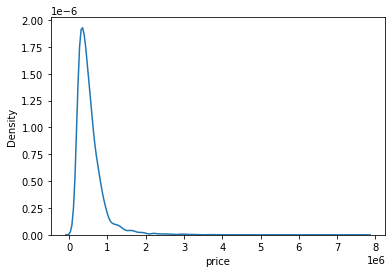

In [155]:
sns.kdeplot(y)
plt.show()

In [156]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

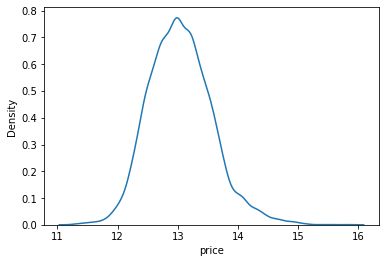

In [157]:
sns.kdeplot(y)
plt.show()

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

zipcode는 다섯자리로 된 숫자형의 데이터 인데, 데이터를 보면 앞의 두자리는 98로 동일하다.
그래서 뒤의 세 자리의 숫자를 여러가지 방법으로 쪼개서 새로운 feature를 만들어 보자.

In [159]:
from sklearn.preprocessing import LabelEncoder

train['zipcode'] = train['zipcode'].astype(str)
train['zipcode-3'] = 'z_' + train['zipcode'].str[2:3]
train['zipcode-4'] = 'z_' + train['zipcode'].str[3:4]
train['zipcode-5'] = 'z_' + train['zipcode'].str[4:5]
train['zipcode-34'] = 'z_' + train['zipcode'].str[2:4]
train['zipcode-45'] = 'z_' + train['zipcode'].str[3:5]
train['zipcode-35'] = 'z_' + train['zipcode'].str[2:3] + train['zipcode'].str[4:5]
train['zipcode'] = train['zipcode'].astype(int)

test['zipcode'] = test['zipcode'].astype(str)
test['zipcode-3'] = 'z_' + test['zipcode'].str[2:3]
test['zipcode-4'] = 'z_' + test['zipcode'].str[3:4]
test['zipcode-5'] = 'z_' + test['zipcode'].str[4:5]
test['zipcode-34'] = 'z_' + test['zipcode'].str[2:4]
test['zipcode-45'] = 'z_' + test['zipcode'].str[3:5]
test['zipcode-35'] = 'z_' + test['zipcode'].str[2:3] + test['zipcode'].str[4:5]
test['zipcode'] = test['zipcode'].astype(int)

encoder = LabelEncoder()

encode_label = encoder.fit(train['zipcode-3'].values)
train['zipcode-3'] = encode_label.transform(train['zipcode-3'].values)
test['zipcode-3'] = encode_label.transform(test['zipcode-3'].values)

encode_label = encoder.fit(train['zipcode-4'].values)
train['zipcode-4'] = encode_label.transform(train['zipcode-4'].values)
test['zipcode-4'] = encode_label.transform(test['zipcode-4'].values)

encode_label = encoder.fit(train['zipcode-5'].values)
train['zipcode-5'] = encode_label.transform(train['zipcode-5'].values)
test['zipcode-5'] = encode_label.transform(test['zipcode-5'].values)

encode_label = encoder.fit(train['zipcode-34'].values)
train['zipcode-34'] = encode_label.transform(train['zipcode-34'].values)
test['zipcode-34'] = encode_label.transform(test['zipcode-34'].values)

encode_label = encoder.fit(train['zipcode-45'].values)
train['zipcode-45'] = encode_label.transform(train['zipcode-45'].values)
test['zipcode-45'] = encode_label.transform(test['zipcode-45'].values)

encode_label = encoder.fit(train['zipcode-35'].values)
train['zipcode-35'] = encode_label.transform(train['zipcode-35'].values)
test['zipcode-35'] = encode_label.transform(test['zipcode-35'].values)

display(train)
display(test)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,1,7,8,16,54,16
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,0,2,8,2,24,8
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,0,7,4,7,51,4
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,0,0,3,0,2,3
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,...,47.4095,-122.315,1650,9711,1,9,8,18,57,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,20141014T000000,4,2.50,2520,6023,2.0,0,0,3,9,...,47.5137,-122.167,2520,6023,0,5,6,5,43,6
15031,20150326T000000,4,3.50,3510,7200,2.0,0,0,3,9,...,47.5537,-122.398,2050,6200,1,3,6,12,31,14
15032,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,...,47.6993,-122.346,1530,1509,1,0,3,9,2,11
15033,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,...,47.5107,-122.362,1830,7200,1,4,6,13,38,14


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,...,47.7210,-122.319,1690,7639,1,2,5,11,21,13
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,...,47.5208,-122.393,1360,5000,1,3,6,12,31,14
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,...,47.6561,-122.005,4760,101930,0,5,3,5,41,3
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,...,47.5123,-122.337,1780,8113,1,4,6,13,38,14
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,...,47.3684,-122.031,2390,7570,0,3,8,3,32,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,...,47.3095,-122.002,1320,11303,0,1,0,1,9,0
6464,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,...,47.5699,-122.288,1400,1230,1,4,4,13,36,12
6465,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,...,47.5773,-122.409,1330,1265,1,1,6,10,14,14
6466,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,...,47.5944,-122.299,1020,2007,1,4,4,13,36,12


In [160]:
train['date(new)'] = train['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
train['how_old'] = train['date'].apply(lambda x: x[:4]).astype(int) - train[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    
test['date(new)'] = test['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
test['how_old'] = test['date'].apply(lambda x: x[:4]).astype(int) - test[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식

train['yr_built'] = train['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 
test['yr_built'] = test['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 

display(train['yr_built'])
display(test['yr_built'])

0         55
1         33
2         87
3         95
4         63
        ... 
15030    114
15031    109
15032    109
15033    114
15034    108
Name: yr_built, Length: 15035, dtype: int64

0        51
1        65
2       101
3        60
4       103
       ... 
6463    114
6464    114
6465    108
6466    109
6467    104
Name: yr_built, Length: 6468, dtype: int64

In [161]:
# sqft 관련
train['sqft_diff'] = train['sqft_living15'] - train['sqft_living']
train['sqft_living_lot_diff'] = train['sqft_lot'] - train['sqft_living']
#df['sqft_living_lot_div'] = df['sqft_living'] / df['sqft_lot']
del train['sqft_lot15'], train['yr_renovated'], train['sqft_lot'], train['date']#, train['waterfront']#, train['view'], train['condition']

test['sqft_diff'] = test['sqft_living15'] - test['sqft_living']
test['sqft_living_lot_diff'] = test['sqft_lot'] - test['sqft_living']
#df['sqft_living_lot_div'] = df['sqft_living'] / df['sqft_lot']
del test['sqft_lot15'], test['yr_renovated'], test['sqft_lot'], test['date']#, test['waterfront']#, test['view'], test['condition']

display(train[['sqft_diff', 'sqft_living_lot_diff']])
display(test[['sqft_diff', 'sqft_living_lot_diff']])

,sqft_diff,sqft_living_lot_diff
0,160,4470
1,1950,9230
2,120,6400
3,523,5104
4,590,8651
...,...,...
15030,0,3503
15031,-1460,3690
15032,0,-399
15033,-480,3503


,sqft_diff,sqft_living_lot_diff
0,-880,4672
1,-600,3040
2,-660,96510
3,0,5690
4,500,4670
...,...,...
6463,-180,10468
6464,-90,-364
6465,20,-16
6466,0,330


In [162]:
# 거리 관련
def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train['haversine_dist']= haversine_array(train['lat'], train['long']) # 중심가로부터의 거리 (haversine_dist)
train['haversine_dist_low'] = haversine_array_low(train['lat'], train['long'])

test['haversine_dist']= haversine_array(test['lat'], test['long']) # 중심가로부터의 거리 (haversine_dist)
test['haversine_dist_low'] = haversine_array_low(test['lat'], test['long'])
#df['min_haver_multi'] = df['min_haver'] * df['haversine_dist'] 

display(train[['haversine_dist', 'haversine_dist_low']])
display(test[['haversine_dist', 'haversine_dist_low']])

,haversine_dist,haversine_dist_low
0,13.498442,14.386052
1,12.037335,39.588215
2,13.197328,30.198213
3,36.512528,10.047953
4,25.535241,5.962297
...,...,...
15030,13.529397,15.831826
15031,15.816422,22.211302
15032,12.182420,36.056265
15033,17.013589,16.720773


,haversine_dist,haversine_dist_low
0,12.543108,38.080394
1,17.772290,18.939902
2,16.366580,35.485133
3,15.758447,15.991418
4,32.368760,16.335074
...,...,...
6463,39.224549,20.142545
6464,8.405682,21.119531
6465,15.333924,24.896159
6466,7.123176,23.938817


### 신규 Feature 설명

* min_haver : 이웃 중 가장 가까운 곳과의 거리 (허태명님의 커널 참고)
* zip_12 : zipcode 중 98을 제외한 1,2번째 숫자 (허태명님의 커널 참고)
* sqft_total_size : sqft_above + sqft_basement
* std, mean, count : std, mean은 zipcode별 price/sqft_total_size의 표준편차, 평균, count는 zipcode별 count 횟수
* date(new), how_old : (DongGyu Lee님의 커널 참고)
* sqft_diff : sqft_living15 - sqft_living
* sqft_living_lot_diff : sqft_lot - sqft_living
* sqft_bedrooms : sqft_living / (sqft_bedrooms + 1)
* sum_level : grade + view + condition
* multi_level : grade view condition
* sum_level_2 : view + condition(3미만인 것은 0으로 치환) + grade
* low_all : condtion(2이하는 0, 나머지는 1) + view(0인것은 0 나머지는 1) + bath(1미만은 0 나머지는 1) + bed(1이면 0 나머지는 1) + grade(6이하면 0, 나머지는 1) + waterfront
* haversine_dist : 47.63, -122.22으로부터 거리
* haversine_dist_low : 47.382, -122.247
* km_120 : 120개로 KMeans 클러스터링 lat, long
* km_pre : price와 km_120 KMeans 클러스터링 후 test set에는 merge

# 모델 튜닝
---

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


## Score 확인
---

In [164]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [165]:
#get_scores(models, train, y)

## 최적 파라미터
---

In [166]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

def my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    for model in models:
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                                  cv=5, verbose=verbose, n_jobs=n_jobs)

        # 모델 fitting
        grid_model.fit(train, y)

        # 결과값 저장
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']

        # 데이터 프레임 생성
        results = pd.DataFrame(params)
        results['score'] = score

        # RMSLE 값 계산 후 정렬
        results['RMSLE'] = np.sqrt(-1 * results['score'])
        results = results.sort_values('RMSLE')
        
        display(results)

In [167]:
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [1, 10, 20],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt'],
# }
# #models = [gboost, xgboost, lightgbm, rdforest]

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# display(my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5))


In [168]:
%%time
dtrain = lgb.Dataset(train, label=y)
dtest  = lgb.Dataset(test)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leave' : 1,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'gpu_id':0,         
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'refit':True,
    'metric' : 'rmse',
    'seed' : 2019
}

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)

print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)
lgb_pred_log = model_lgb.predict(test)
lgb_pred = np.expm1(lgb_pred_log)

[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[Ligh

In [169]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 1984
}

# transform
dtrain = xgb.DMatrix(train, y)
dtest = xgb.DMatrix(test)

def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

# # plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
# ax1.set_title('RMSE_log', fontsize=20)
# cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
# ax2.set_title('RMSE', fontsize=20)

# plt.show()

[13:39:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squar

## Asemble
---

In [172]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)

# Sub mission save
---

In [173]:
submission = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/sample_submission.csv')
submission['price'] = ensemble_pred
submission.to_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_js.csv', index=False)

# 최종 Private Score
---

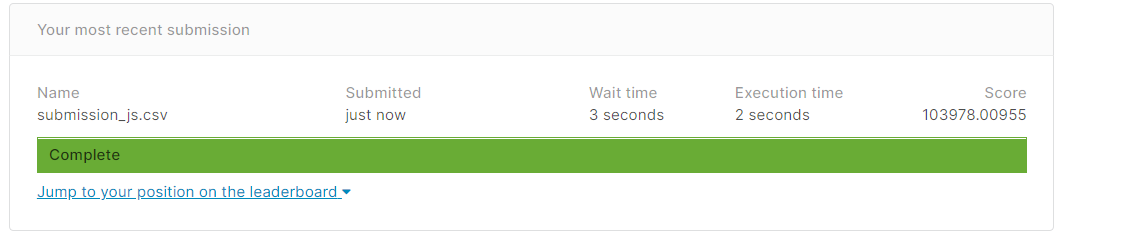

# 회고
---

- 이번 프로젝트에서 **어려웠던 점,**       
: GridSearch로 최적 파라미터 찾는 시간이 너무 오래걸려서 힘들었다.
Private Score가 118000 대에서 내려오질 않아 힘들었다.

- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
: 모델 수정 또는 하이퍼 파라미터 변경 보다 데이터 전처리가 훨씬 중요하단걸 알았다.
여러모델을 앙상블하여 쓰는것 보다 성능좋은 모델 2개를 앙상블하여 쓰는게 성능이 더 좋다.

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
: gboost, xgboost, lightgbm, rdforest모델을 앙상블 하여 사용했지만 효과는 미비했다. 
GridSearch 로 2시간30분동안 최적의 하이퍼 파라미터 찾아 모델을 학습시켰지만 Private Score는 118500에서 100도 안떨어졌다...
결국 여러 커널들을 참고하게 됐는데, 컬럼 간의 관계를 보고 파생 변수(새로운 컬럼)을 추가하는 피처 엔지니어링을 보고서 참고하였다.
또한 여러 커널들을 봤을때 성능이 좋은 모델 1개 혹은 2개 정도만 써서 점수가 높은걸 확인하였고, 2개의 모델(xgboost, lightgbm)을 train하여 앙상블한 결과로 측정하였을 때 Private Score가 루브릭 기준을 넘길 수 있었다.

- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**
: Feature Engeering을 통해 여러 시도를 해보고 컬럼들간의 상관관계를 파악하는 연습을 하자.
여러 커널들을 분석하여 인사이트를 높히자